In [6]:
import csv, pyodbc

# set up some constants
MDB = 'txt_db/vqa_train.db/data.mdb'
DRV = '{Microsoft Access Driver (*.mdb, *.accdb)}'

# connect to db
con = pyodbc.connect('DRIVER={};DBQ={}'.format(DRV,MDB))
cur = con.cursor()

Error: ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'Microsoft Access Driver (*.mdb, *.accdb)' : file not found (0) (SQLDriverConnect)")

### add parent dir

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import lmdb
from lz4.frame import compress, decompress
import msgpack
import json
import re
import torch

class TxtLmdb(object):
    def __init__(self, db_dir, readonly=True):
        self.readonly = readonly
        if readonly:
            # training
            self.env = lmdb.open(db_dir,
                                 readonly=True, create=False)
            self.txn = self.env.begin(buffers=True)
            self.write_cnt = None
        else:
            # prepro
            self.env = lmdb.open(db_dir, readonly=False, create=True,
                                 map_size=4 * 1024**4)
            self.txn = self.env.begin(write=True)
            self.write_cnt = 0

    def __del__(self):
        if self.write_cnt:
            self.txn.commit()
        self.env.close()

    def __getitem__(self, key):
        return msgpack.loads(decompress(self.txn.get(key.encode('utf-8'))))

    def __setitem__(self, key, value):
        # NOTE: not thread safe
        if self.readonly:
            raise ValueError('readonly text DB')
        ret = self.txn.put(key.encode('utf-8'),
                           compress(msgpack.dumps(value, use_bin_type=True)))
        self.write_cnt += 1
        if self.write_cnt % 1000 == 0:
            self.txn.commit()
            self.txn = self.env.begin(write=True)
            self.write_cnt = 0
        return ret


# Using TxtLmdb

In [30]:
txt_db = TxtLmdb('txt_db/vqa_devval.db', readonly=True)

In [31]:
out = txt_db['262148000']
out

{b'answer_type': b'other',
 b'answers': [{b'answer': b'down',
   b'answer_confidence': b'yes',
   b'answer_id': 1},
  {b'answer': b'down', b'answer_confidence': b'yes', b'answer_id': 2},
  {b'answer': b'at table', b'answer_confidence': b'yes', b'answer_id': 3},
  {b'answer': b'skateboard', b'answer_confidence': b'yes', b'answer_id': 4},
  {b'answer': b'down', b'answer_confidence': b'yes', b'answer_id': 5},
  {b'answer': b'table', b'answer_confidence': b'yes', b'answer_id': 6},
  {b'answer': b'down', b'answer_confidence': b'yes', b'answer_id': 7},
  {b'answer': b'down', b'answer_confidence': b'yes', b'answer_id': 8},
  {b'answer': b'down', b'answer_confidence': b'yes', b'answer_id': 9},
  {b'answer': b'down', b'answer_confidence': b'yes', b'answer_id': 10}],
 b'image_id': 262148,
 b'img_fname': b'coco_val2014_000000262148.npz',
 b'input_ids': [2777, 1110, 1119, 1702, 136],
 b'multiple_choice_answer': b'down',
 b'question': b'Where is he looking?',
 b'question_id': 262148000,
 b'question

In [46]:
logits = torch.as_tensor([[.2,.4,.2,.9]])
labels = torch.as_tensor([[1, 0,.3, .3]])
logits = torch.max(logits, 1)[1]  # argmax
one_hots = torch.zeros(*labels.size(), device=labels.device)
one_hots.scatter_(1, logits.view(-1, 1), 1)
scores = (one_hots * labels)
scores

tensor([[0.0000, 0.0000, 0.0000, 0.3000]])

# Looking at dataset structure

In [22]:
env = lmdb.open('txt_db/vqa_devval.db', readonly=False, create=True,
                                 map_size=4 * 1024**4)

In [23]:
txn = env.begin()
txn.stat()

{'branch_pages': 37,
 'depth': 3,
 'entries': 26280,
 'leaf_pages': 4617,
 'overflow_pages': 0,
 'psize': 4096}

In [24]:
cursor = txn.cursor()

In [28]:
cursor.first()

True

In [29]:
key, value = cursor.item()

In [31]:
out = txn.get('100001000'.encode('utf-8'))
out

b'\x04"M\x18h@\x0e\x03\x00\x00\x00\x00\x00\x00Pi\x01\x00\x00\xf4(\x8b\xa8image_id\xce\x00\x01\x86\xa1\xa8question\xbdWhere was this picture taken?\xab\'\x00\x008\x00\xb4\x05\xf5\xe4\xe8\xaetoked_\x17\x00!\x96\xa5?\x00P\xa3was\xa4?\x00\x13\xa7?\x00\x11\xa5?\x00\xf1*\xa3@@?\xa9input_ids\x96\xcd\n\xd9\xcd\x04T\xcd\x04v\xcd\ro\xcd\x06\x8e\xcc\x88\xa9img_fname\xbdcoco_val2014_0\x01\x00\x101\x06\x00d1.npz\xado\x00\xf2&_type\xb1none of the above\xb6multiple_choice_answer\xa5beach\xa7\r\x00Bs\x9a\x83\xa6\n\x00\x02\x17\x00\x12\xb1\r\x00\xf3\x01_confidence\xa3yes\xa9\x16\x00?id\x01/\x00\x1b\x1f\x02/\x00\x1b\x1f\x03/\x00\x1b\x1f\x04/\x00\x1b\x1f\x05/\x00\x1b\x1f\x06/\x00\x1b\x1f\x07/\x00\x1b\x1f\x08/\x00\x1b\x1f\t/\x00\x1b#\n\xab\xb2\x01\x00\x1a\x02\xf0\x1b\xa5other\xa6target\x82\xa6labels\x91\xcd\x01\x07\xa6scores\x91\xcb?\xf0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [32]:
msgpack.loads(decompress(out))

{b'answer_type': b'other',
 b'answers': [{b'answer': b'beach',
   b'answer_confidence': b'yes',
   b'answer_id': 1},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 2},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 3},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 4},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 5},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 6},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 7},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 8},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 9},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 10}],
 b'image_id': 100001,
 b'img_fname': b'coco_val2014_000000100001.npz',
 b'input_ids': [2777, 1108, 1142, 3439, 1678, 136],
 b'multiple_choice_answer': b'beach',
 b'question': b'Where was this picture taken?',
 b'question_id': 1000010

In [53]:
out = txn.get('asdfa'.encode('utf-8'))
out == None

True

In [30]:
key.decode()

'100001000'

In [55]:
q = msgpack.loads(decompress(value))
q

{b'answer_type': b'other',
 b'answers': [{b'answer': b'beach',
   b'answer_confidence': b'yes',
   b'answer_id': 1},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 2},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 3},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 4},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 5},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 6},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 7},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 8},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 9},
  {b'answer': b'beach', b'answer_confidence': b'yes', b'answer_id': 10}],
 b'image_id': 100001,
 b'img_fname': b'coco_val2014_000000100001.npz',
 b'input_ids': [2777, 1108, 1142, 3439, 1678, 136],
 b'multiple_choice_answer': b'beach',
 b'question': b'Where was this picture taken?',
 b'question_id': 1000010

In [70]:
msgpack.loads(decompress(compress(msgpack.dumps(q)))) == q

True

NameError: name 'torch' is not defined

In [82]:
q['img_fname'.encode('utf-8')].decode()

'vg_000000150305.npz'

In [10]:
q['question'.encode('utf-8')].decode().split(" ")

['What', 'color', 'is', 'the', 'bucket', 'on', 'the', 'heater?']

# Getting words in VQA

In [66]:


def get_q_info(key, value):
    # get the id for the question
    q_id = key.decode()
    # get the row from the db for a given question
    q = msgpack.loads(decompress(value))
    # get the question as a string
    q_text= q['question'.encode('utf-8')].decode()
    # want to remove the question mark for analysis
    if q_text[-1] == '?':
        q_text = q_text[0:-1]
    # turn the actual question into an set of strings
    q_set = set(q_text.split(" "))
    q_set = set(filter(lambda x: x != '',q_set))
    return q_id, q_text, q_set

def update_dict(key, value, word_dict, word_dict_counts):
    q_id, _, q_set = get_q_info(key, value)
    for word in q_set:
        if word not in word_dict:
            word_dict[word] = [q_id]
            word_dict_counts[word] = 1
        else:
            word_dict[word].append(q_id)
            word_dict_counts[word] +=1

def get_cursor(db):
    env = lmdb.open('txt_db/{}'.format(db), readonly=False, create=True,
                                 map_size=4 * 1024**4)
    txn = env.begin()
    cursor = txn.cursor()
    return cursor
            
def enumerate_db(db, word_dict, word_dict_counts):
    print("#### DOING {} ####".format(db))
    cursor = get_cursor(db)
    for key, value in cursor:
        update_dict(key, value, word_dict, word_dict_counts)
        
def count_number_of_questions(db):
    print("#### COUNTING {} ####".format(db))
    cursor = get_cursor(db)
    count = 0
    for key, value in cursor:
        count += 1
    return count

def count_valid_questions(db, word_set):
    print("#### COUNTING VALID {} ####".format(db))
    cursor = get_cursor(db)
    count = 0
    for key, value in cursor:
        _, _, q_set = get_q_info(key, value)
        if len(q_set.intersection(word_set)) != 0:
            count += 1
    return count

In [67]:
# no'vqa_test.db'
list_of_data = ['vqa_devval.db', 'vqa_train.db', 'vqa_trainval.db', 'vqa_vg.db']
word_dict = {}
word_dict_counts = {}

In [3]:
import lmdb
from lz4.frame import compress, decompress
import msgpack

for db in list_of_data:
    enumerate_db(db, word_dict, word_dict_counts)


#### DOING vqa_devval.db ####
#### DOING vqa_train.db ####
#### DOING vqa_trainval.db ####
#### DOING vqa_vg.db ####


In [4]:
num_questions = 0
for db in list_of_data:
    num_questions += count_number_of_questions(db)
num_questions

#### COUNTING vqa_devval.db ####
#### COUNTING vqa_train.db ####
#### COUNTING vqa_trainval.db ####
#### COUNTING vqa_vg.db ####


1129238

In [7]:
with open('vqa_word_counts.json', 'w') as outfile:
    json.dump(word_dict_counts, outfile)
with open('vqa_word_questions.json', 'w') as outfile:
    json.dump(word_dict, outfile)

# Getting the diff of words in bert

In [8]:
def read_file_as_list(file_name):
    with open(file_name) as file:
        return [line.strip() for line in file]

In [9]:
bert_vocab_set = set(read_file_as_list('bert_vocab/vocab.txt'))
word_dict_counts = {}
with open('vqa_word_counts.json') as infile:
    word_dict_counts = json.load(infile)

In [10]:
def is_oov_cleaned(word, vocab):
    if word in vocab:
        return False
    if len(word) > 1 and word[-1] == 's' and word[0:-1] in vocab:
        return False
    if len(word) > 2 and word[-2] == "'" and word[0:-2] in vocab:
        return False
    return True

In [11]:
vqa_words_not_in_bert = {}
for key in word_dict_counts.keys():
    if key not in bert_vocab_set:
        vqa_words_not_in_bert[key] = word_dict_counts[key]


In [12]:
with open('vqa_words_not_in_bert.txt', 'w') as outfile:
    json.dump(vqa_words_not_in_bert, outfile)

In [13]:
vqa_words_not_in_bert

{'kites': 1490,
 'kite': 2765,
 'stickers': 242,
 'stoplight': 153,
 "person's": 2965,
 'rained': 79,
 'zebra': 3482,
 "it's": 606,
 'giraffe': 5068,
 'zebras': 4166,
 'federally-mandated': 1,
 "What's": 3828,
 'giraffes': 4184,
 'raining': 1386,
 'light.': 2,
 "phone's": 23,
 'suitcases': 617,
 "man's": 14332,
 'utensil': 1182,
 'hydrant': 3182,
 'donuts': 1441,
 'leash': 269,
 'motorhomes': 1,
 'opaque': 33,
 'cooks': 42,
 'chefs': 68,
 'blinds': 407,
 'unmade': 18,
 'futon': 15,
 "someone's": 367,
 'Frisbee': 579,
 'cabbage': 40,
 'bananas': 2388,
 'pears': 37,
 'seasoned': 15,
 'sepia': 14,
 "woman's": 6036,
 'purses': 23,
 'Asians': 9,
 'handbag': 47,
 'umbrellas': 2150,
 "child's": 1050,
 'pedestrians': 104,
 'surfboard': 2520,
 'living,': 5,
 'corner,': 7,
 'squatting': 131,
 "catcher's": 250,
 'divisible': 3,
 'servings': 35,
 'oats': 2,
 "girl's": 1948,
 'indoors': 667,
 'earrings': 172,
 "kid's": 161,
 'Glazed': 2,
 'doughnuts': 489,
 'doughnut': 391,
 'muffins': 51,
 'skateb

In [68]:
num_remaining_questions = 0
for db in list_of_data:
    num_remaining_questions += count_valid_questions(db, set(vqa_words_not_in_bert.keys()))
num_remaining_questions

#### COUNTING VALID vqa_devval.db ####
#### COUNTING VALID vqa_train.db ####
#### COUNTING VALID vqa_trainval.db ####
#### COUNTING VALID vqa_vg.db ####


211647

# Splitting Test to Val

In [15]:
vqa_full_test_words = {}
with open('vqa_words_not_in_bert.txt') as infile:
    vqa_full_test_words = json.load(infile)

In [16]:
full_word_list = list(vqa_full_test_words)
full_word_list.sort()
full_word_list

['"&"',
 '"+"',
 '"11"',
 '"1560',
 '"300"',
 '"4"',
 '"40"',
 '"41"',
 '"50"',
 '"6',
 '"6"',
 '"70"',
 '"911"',
 '"A"',
 '"A49"',
 '"AHH"',
 '"ANTIQUE"',
 '"ATM"',
 '"AVE"',
 '"African"',
 '"Ahead"',
 '"Air',
 '"Ajax"',
 '"Alive"',
 '"All',
 '"Amazing"',
 '"Asian"',
 '"Automat"',
 '"B"',
 '"BACK',
 '"BELLTOWN"',
 '"BRAT"',
 '"BREAK"',
 '"BRITISH',
 '"BURGER"',
 '"Baby',
 '"Bar"',
 '"Bet"',
 '"Big',
 '"Black',
 '"Born',
 '"Braden',
 '"Brigantine"',
 '"Brooklyn',
 '"Brown',
 '"Buildstrong"',
 '"Butt',
 '"C"',
 '"COAL',
 '"COCINA"',
 '"COMMUNITY"',
 '"California"',
 '"Casey"',
 '"Cash"',
 '"Catalunya"',
 '"Cedar"',
 '"Central"',
 '"Chicago"',
 '"D"',
 '"DB"',
 '"DELL"',
 '"DONUTS"',
 '"Dainty',
 '"Dell"',
 '"Dimple"',
 '"Do',
 '"Downtown"',
 '"E"',
 '"EASON"',
 '"EAST',
 '"ECOLIERS"',
 '"EMR"',
 '"ESPN',
 '"Easy"',
 '"Eat',
 '"El"',
 '"Evil',
 '"Ex"',
 '"Exploring',
 '"F"',
 '"FANTA"',
 '"FLORIDA"',
 '"FN437"',
 '"FOR',
 '"FRANCE"',
 '"FRIDAY"',
 '"FULLY',
 '"Field',
 '"Flash',
 '"For',

In [61]:
def get_base_words(word):
    cleaned_word = re.sub(r'[^a-zA-Z\d\s:]', '', word)
    cleaned_word = cleaned_word.strip()
    cleaned_word = cleaned_word.lower()
    if len(cleaned_word) > 3 and cleaned_word[-3:] == 'ing':
        return [cleaned_word, cleaned_word[0:-3]]
    if len(cleaned_word) > 3 and cleaned_word[-3:] == 'ers':
        return [cleaned_word, cleaned_word[0:-2], cleaned_word[0:-1], cleaned_word[0:-3]]
    if len(cleaned_word) > 2 and cleaned_word[-2:] == 'es':
        return [cleaned_word, cleaned_word[0:-2], cleaned_word[0:-1]]
    if len(cleaned_word) > 2 and cleaned_word[-2:] == 'ed':
        return [cleaned_word, cleaned_word[0:-2], cleaned_word[0:-1]]
    if len(cleaned_word) > 2 and cleaned_word[-2:] == 'er':
        return [cleaned_word, cleaned_word[0:-2], cleaned_word[0:-1]]
    if len(cleaned_word) > 1 and cleaned_word[-1] == 's':
        return [cleaned_word, cleaned_word[0:-1]]
    return [cleaned_word]
    
def check_words_against_set(words, s):
    for word in words:
        if word in s:
            return True
    return False

def add_word_to_list(word, base_words, word_list, word_set, word_dict):
    word_list.append(word)
    for w in base_words:
        word_set.add(w)
    return word_dict[word]

In [62]:
get_base_words('kites,')

['kites', 'kit', 'kite']

In [63]:
words_1 = []
words_2 = []
set1 = set()
set2 = set()
count_1 = 0
count_2 = 0
for word in full_word_list:
    base_words = get_base_words(word)
    if check_words_against_set(base_words, set1):
        count_1 += add_word_to_list(word, base_words, words_1, set1, vqa_full_test_words)
    elif check_words_against_set(base_words, set2):
        count_2 += add_word_to_list(word, base_words, words_2, set2, vqa_full_test_words)
    elif count_1 <= count_2:
        count_1 += add_word_to_list(word, base_words, words_1, set1, vqa_full_test_words)
    else:
        count_2 += add_word_to_list(word, base_words, words_2, set2, vqa_full_test_words)
print(count_1)
print(count_2)

119098
106057


In [64]:
def write_list_to_file(l, filename):
    with open(filename, 'w') as openfile:
        for x in l:
            openfile.write(x)
            openfile.write('\n')

In [65]:
write_list_to_file(words_1, 'words_test_set_1.txt')
write_list_to_file(words_2, 'words_test_set_2.txt')

In [70]:
num_test1_questions = 0
for db in list_of_data:
    num_test1_questions += count_valid_questions(db, set(words_1))
num_test1_questions

#### COUNTING VALID vqa_devval.db ####
#### COUNTING VALID vqa_train.db ####
#### COUNTING VALID vqa_trainval.db ####
#### COUNTING VALID vqa_vg.db ####


115585

# Analyzing the Tokenization

In [1]:
%matplotlib notebook
import json
import matplotlib.pyplot as plt

In [14]:
strategy_prefixes = ['all', '2_04']
strategy_prefix = strategy_prefixes[1]
print(strategy_prefix)
num_words_changed = json.load(open(f'oov_analysis/{strategy_prefix}_num_words_changed.json'))
tokenization_types = json.load(open(f'oov_analysis/{strategy_prefix}_tokenization_types.json'))
tokens_count = json.load(open(f'oov_analysis/{strategy_prefix}_tokens_count.json'))
word2count = json.load(open(f'oov_analysis/{strategy_prefix}_word2count.json'))

2_04


In [15]:
d = word2count
l = [(k, v) for k, v in d.items()]
l.sort(key=lambda x:  x[0], reverse = True)
a = [x[0] for x in l]
b = [x[1] for x in l]

plt.bar(a, b)
plt.plot()

[]

<IPython.core.display.Javascript object>


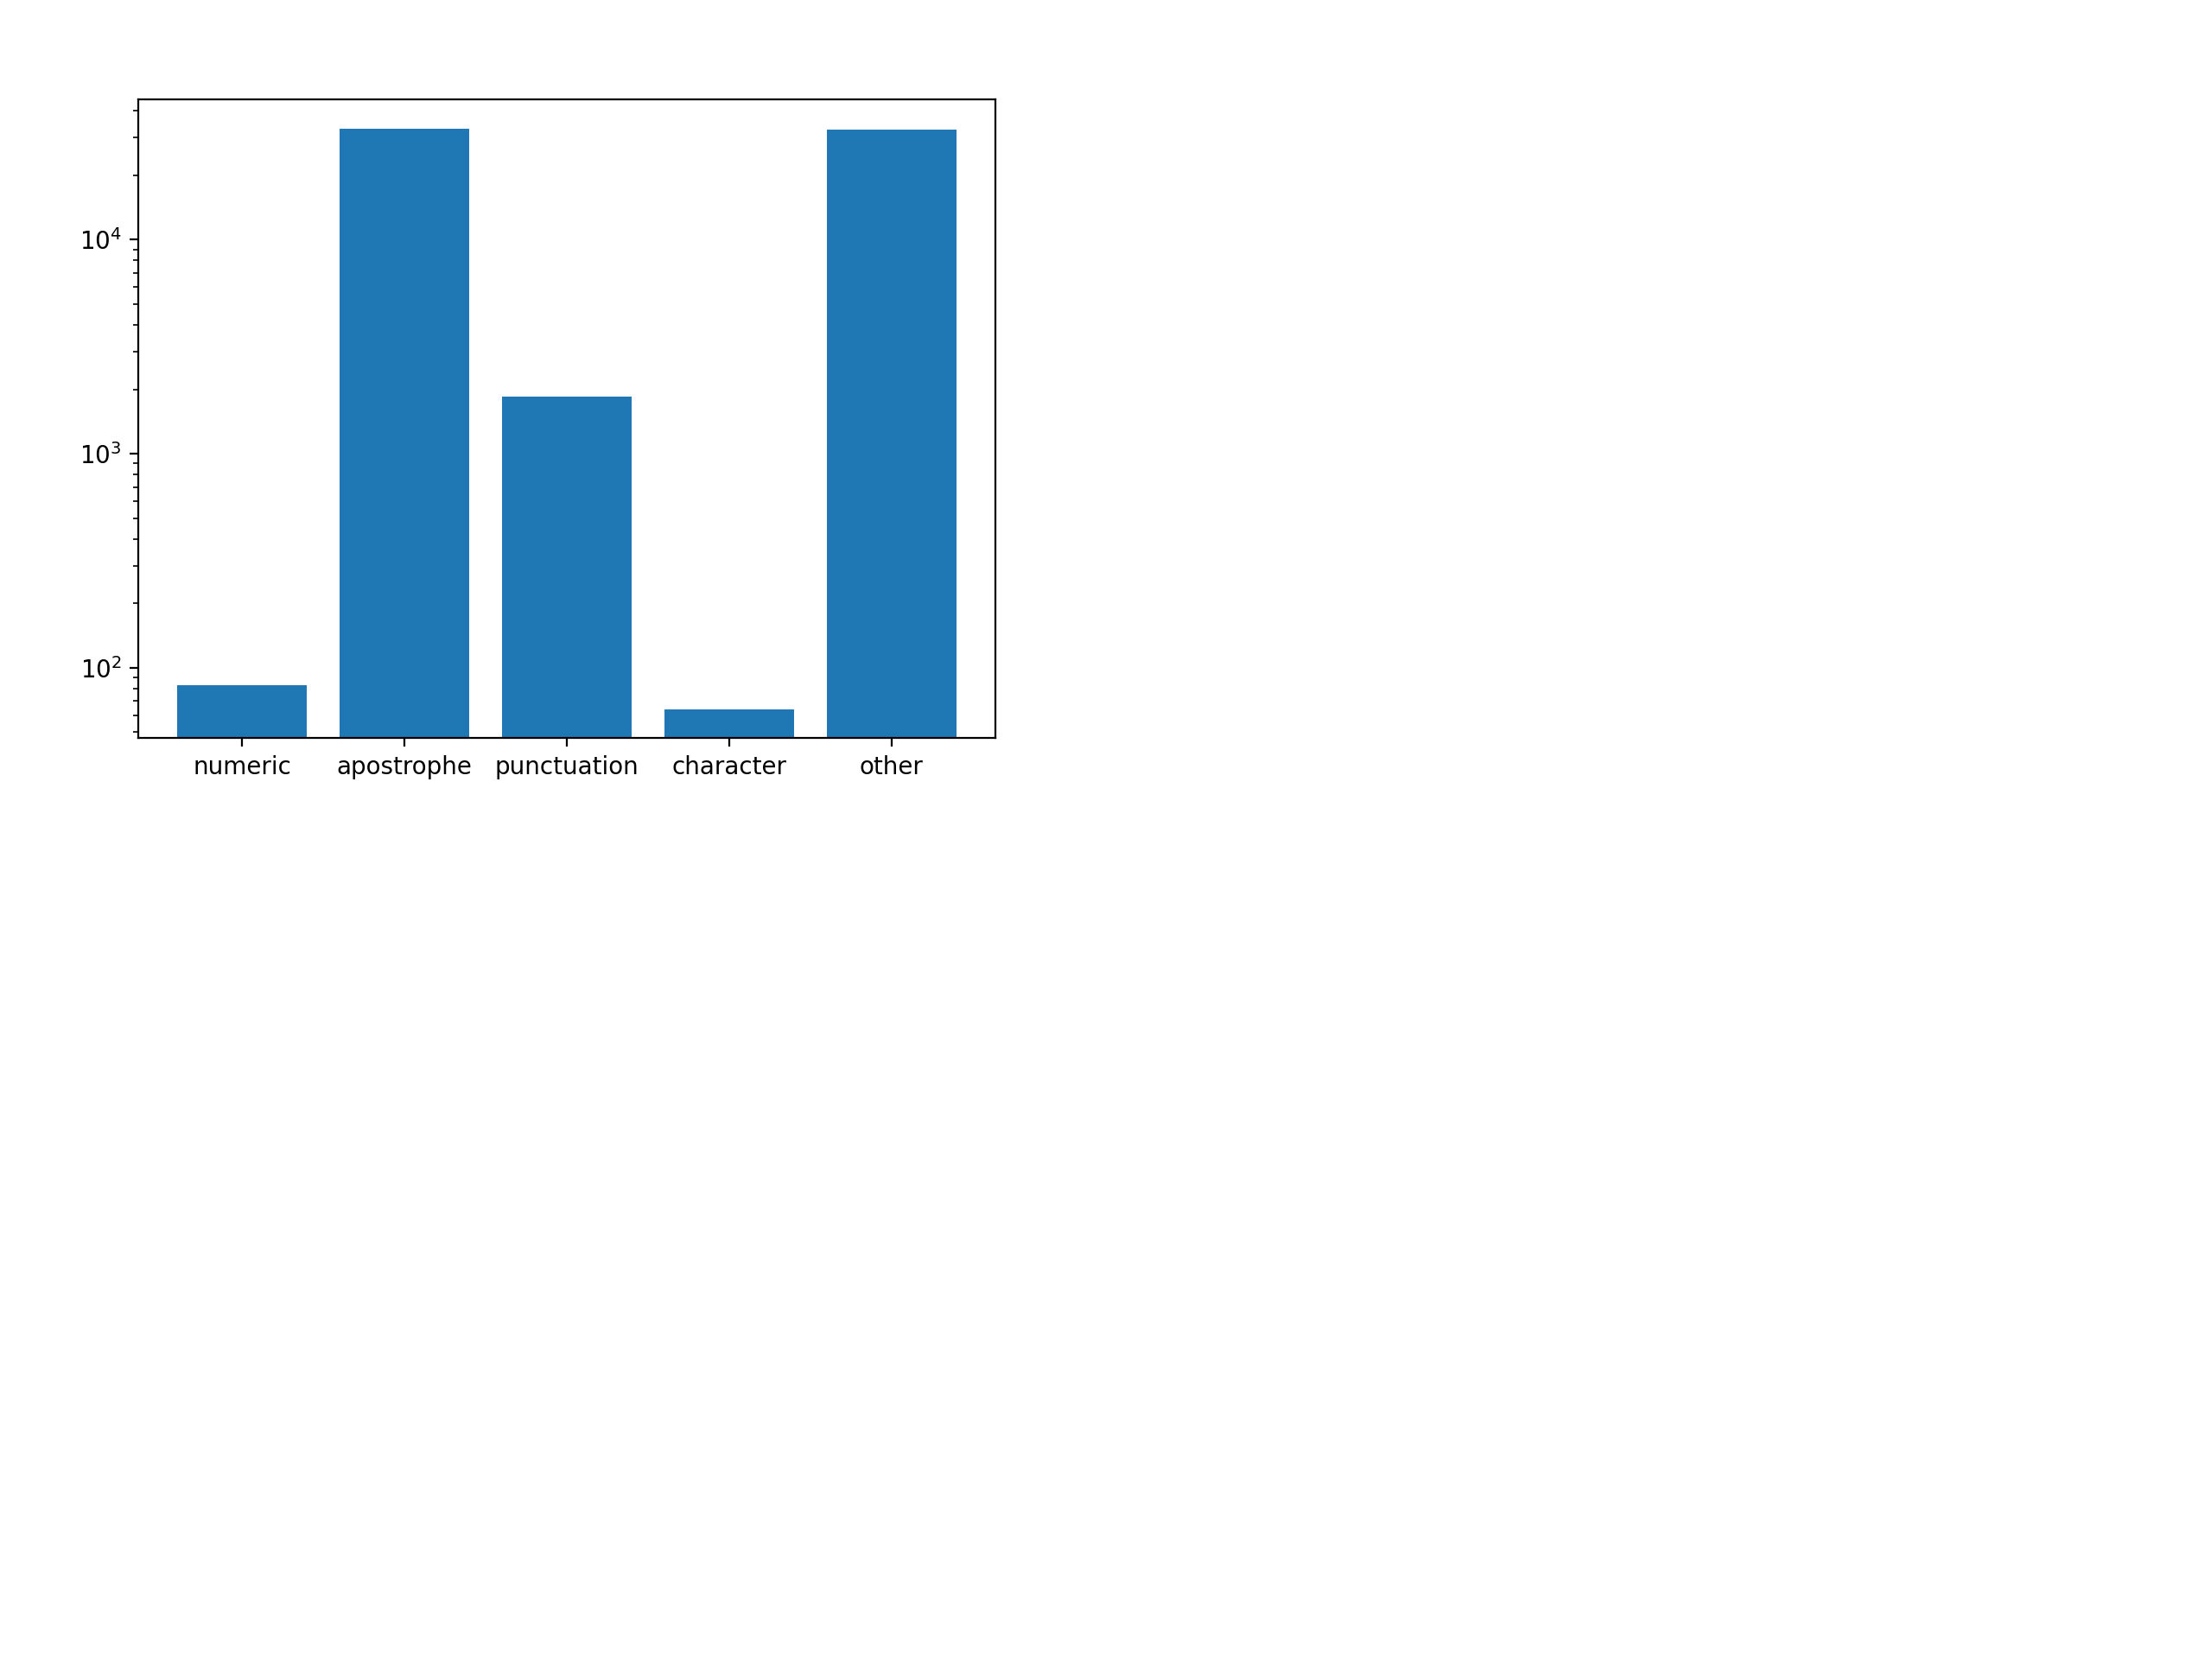

[]

In [16]:
d = tokenization_types
l = []
for k, v in d.items():
    if isinstance(v, int):
        l.append((k,v))
#l.sort(key=lambda x:  x[0])
a = [x[0] for x in l]
b = [x[1] for x in l]

plt.bar(a, b)
plt.yscale('log')
plt.plot()

# Testing stuff

In [31]:
s = "'s"
s[0:-2]

''

In [2]:
from pytorch_pretrained_bert import BertTokenizer

In [3]:
toker =  BertTokenizer.from_pretrained(
        'bert-base-cased')

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.


In [13]:
toker.tokenize('applebottomjeans')

['apple', '##bot', '##tom', '##je', '##ans']

In [80]:
a = [1,23]
a += [1,2,3]
a

[1, 23, 1, 2, 3]

In [18]:
toker.save_vocabulary('bert_vocab')

'bert_vocab/vocab.txt'

In [18]:
"s"[0:-1] == ''

True

In [40]:
re.split(r'[^a-zA-Z\d\s:]', "ASD)(*)A(S*D)()")

['ASD', '', '', '', 'A', 'S', 'D', '', '', '']

In [39]:
re.sub(r'[^a-zA-Z\d\s:]', '', "\"kid's,")

'kids'

In [7]:
'    a.    b.  '.split(' ')

['', '', '', '', 'a.', '', '', '', 'b.', '', '']

In [17]:
"\n\nasdfasf*&)*    \n".strip()

'asdfasf*&)*'

In [17]:
"ADSSD".lower()

'adssd'

In [22]:
a = []
a += 'a'
a

['a']

In [33]:
a = set()
def addset(s, x):
    s.add(x)
addset(a, "a")
a

{'a'}

In [3]:
import torch

In [21]:
scores = torch.as_tensor([[-.1,.2,.3,-.4],[0,-.3,-.4,.5],[-.1,-.34,.53,.2]])

scores = torch.nn.Softmax(dim=1)(scores)

scores#.max(dim=-1, keepdim=False) #[1].cpu().tolist()

tensor([[0.2182, 0.2946, 0.3255, 0.1617],
        [0.2463, 0.1825, 0.1651, 0.4061],
        [0.1994, 0.1569, 0.3745, 0.2692]])